In [29]:
import pandas as pd
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

pd.options.display.max_rows = 20
plt.rcParams.update({"font.size":20})

In [37]:
BTR = pd.read_csv("SD_analysis_bbm-bnet-inputs-true.csv")
BTR.attrs["name"] = "bbm-inputs-true"
BTR.columns = ["model_name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
BTR = BTR.sort_values(by=["model_name"])
BTR = BTR.dropna(subset=["sdsize","sddepth"])

BTR

,model_name,n,sdsize,sddepth,att,maa,mintrap
3,003.bnet,20,1,0,1,0,1
6,005.bnet,28,7,4,1,0,1
2,006.bnet,68,1,0,1,0,1
0,007.bnet,5,3,1,2,0,2
1,008.bnet,28,5,2,3,0,3
...,...,...,...,...,...,...,...
195,208.bnet,15,14,4,5,0,5
196,209.bnet,87,2,1,1,0,1
197,210.bnet,144,2,1,1,0,1
200,211.bnet,183,3,2,1,0,1


In [38]:
RAN = pd.read_csv("random-prototype.csv")
RAN.attrs["name"] = "N-K random"
RAN.columns = ["model_name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
RAN = RAN.sort_values(by=["model_name"])
RAN = RAN.dropna(subset=["sdsize","sddepth"])

In [39]:
NCF = pd.read_csv("SD_analysis_random_ncf.csv")
NCF.attrs["name"] = "NCF random"
NCF.columns = ["model_name", "n", "sdsize", "sddepth", "att", "maa", "mintrap"]
NCF = NCF.sort_values(by=["model_name"])
NCF = NCF.dropna(subset=["sdsize","sddepth"])

NCF

,model_name,n,sdsize,sddepth,att,maa,mintrap
8,n10_0.bnet,10,8,3,3,0,3
3,n10_1.bnet,10,1,0,1,0,1
5,n10_10.bnet,10,2,1,1,0,1
4,n10_11.bnet,10,3,2,1,0,1
2,n10_13.bnet,10,3,1,2,0,2
...,...,...,...,...,...,...,...
586,n80_95.bnet,80,1,0,1,0,1
589,n80_96.bnet,80,3,1,2,0,2
592,n80_97.bnet,80,15,3,4,0,4
593,n80_98.bnet,80,10,3,3,0,3


In [33]:
class PlotVar:
    _label_dict = {
        "n": r"network size",
        "sdsize": r"SD size",
        "sddepth": r"SD depth",
        "att": r"number of attractors",
        "maa": r"number of motif avoidant attractors",
        "mintrap": r"number of minimal trapspaces",
    }

    def __init__(self, data:pd.DataFrame, name: str, minval: float, maxval: float, log:bool=False, trend:bool=False):
        self.data = data
        self.name = name
        self.minval = minval
        self.maxval = maxval
        self.label = self._label_dict[name]
        self.log = log
        self.trend = trend

In [52]:
def monoExp(x, t):
    return np.exp(t * x)

def line(x, t):
    return t * x

def comparison_plots(vars, hlines=None, vlines=None):
    icount = len(vars)
    jcount = len(vars[0])

    fig = plt.figure(figsize=(10 * jcount, 10 * icount))
    fig.set_facecolor("white")

    figs = fig.subfigures(icount, jcount)
    figs = np.reshape(
        figs, (icount, jcount)
    )  # always treat as 2d array, even when only 1 col or row

    for i, j in it.product(range(icount), range(jcount)):
        px, py = vars[i][j]
        data = px.data        
        vx, vy = px.name, py.name
        xmin, xmax = px.minval, px.maxval  # lims[i][j][0]
        ymin, ymax = py.minval, py.maxval  # lims[i][j][1]
        xlog, ylog = px.log, py.log
        ytrend = py.trend
    
        axd = figs[i, j].subplots(1,1)
        axd.set_zorder(10)
        axd.set_title(data.attrs["name"] + " " + py.label + " vs " + px.label)

        if hlines:
            axd.hlines(hlines, xmin, xmax, color="k", linestyle="-.")
        if vlines:
            axd.vlines(vlines, ymin, ymax, color="k", linestyle="-.")
        if xlog:
            axd.set_xscale("log")
        if ylog:
            axd.set_yscale("log")
        if ytrend:
            xs = data[vx].sort_values()
            ys = data[vy].sort_values()

            # direct fit
            p0 = (0.7) # start with values near those we expect
            params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, p0)
            t = params[0]
            # determine quality of the fit
            squaredDiffs = np.square(ys - monoExp(xs, t))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            print(f"direct fit: R² = {rSquared}")
            # plot the results
            xs1 = np.arange(xmin,xmax, 0.1)
            axd.plot(xs1, monoExp(xs1, t), "--", label="fitted_scipy")
            # inspect the parameters
            print(f"direct fit: Y = e^({t} * x)")

            axd.annotate(
                f"Y = e^({round(t,2)} * x)\nR² = {round(rSquared,3)}",
                xy=(0.2, 0.9),
                xycoords = "axes fraction",
                ha="center",
                va="center",
                c="#1f77b4"
            )

            # fit to log
            p0 = (0.7) # start with values near those we expect
            params, cv = scipy.optimize.curve_fit(line, xs, np.log(ys), p0)
            t = params[0]
            # determine quality of the fit
            squaredDiffs = np.square(ys - monoExp(xs, t))
            squaredDiffsFromMean = np.square(ys - np.mean(ys))
            rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
            print(f"log fit: R² = {rSquared}")
            # plot the results
            xs1 = np.arange(xmin,xmax, 0.1)
            axd.plot(xs1, monoExp(xs1, t), "--", label="fitted_scipy")
            # inspect the parameters
            print(f"log fit: Y = e^({t} * x)")

            axd.annotate(
                f"Y = e^({round(t,2)} * x)\nR² = {round(rSquared,3)}",
                xy=(0.2, 0.8),
                xycoords = "axes fraction",
                ha="center",
                va="center",
                c="#ff7f0e"
            )

        axd.scatter(data[vx], data[vy],
            s=100,
            alpha=0.3,
            zorder=10,
            clip_on=False,
        )
        
        axd.set_xlabel(px.label)
        axd.set_ylabel(py.label)
        axd.set_xlim(xmin, xmax)
        axd.set_ylim(ymin, ymax)

        figs[i, j].subplots_adjust(hspace=0.0135, wspace=0.0135)
    fig.subplots_adjust(bottom=0.08, left=0.05)
    return fig

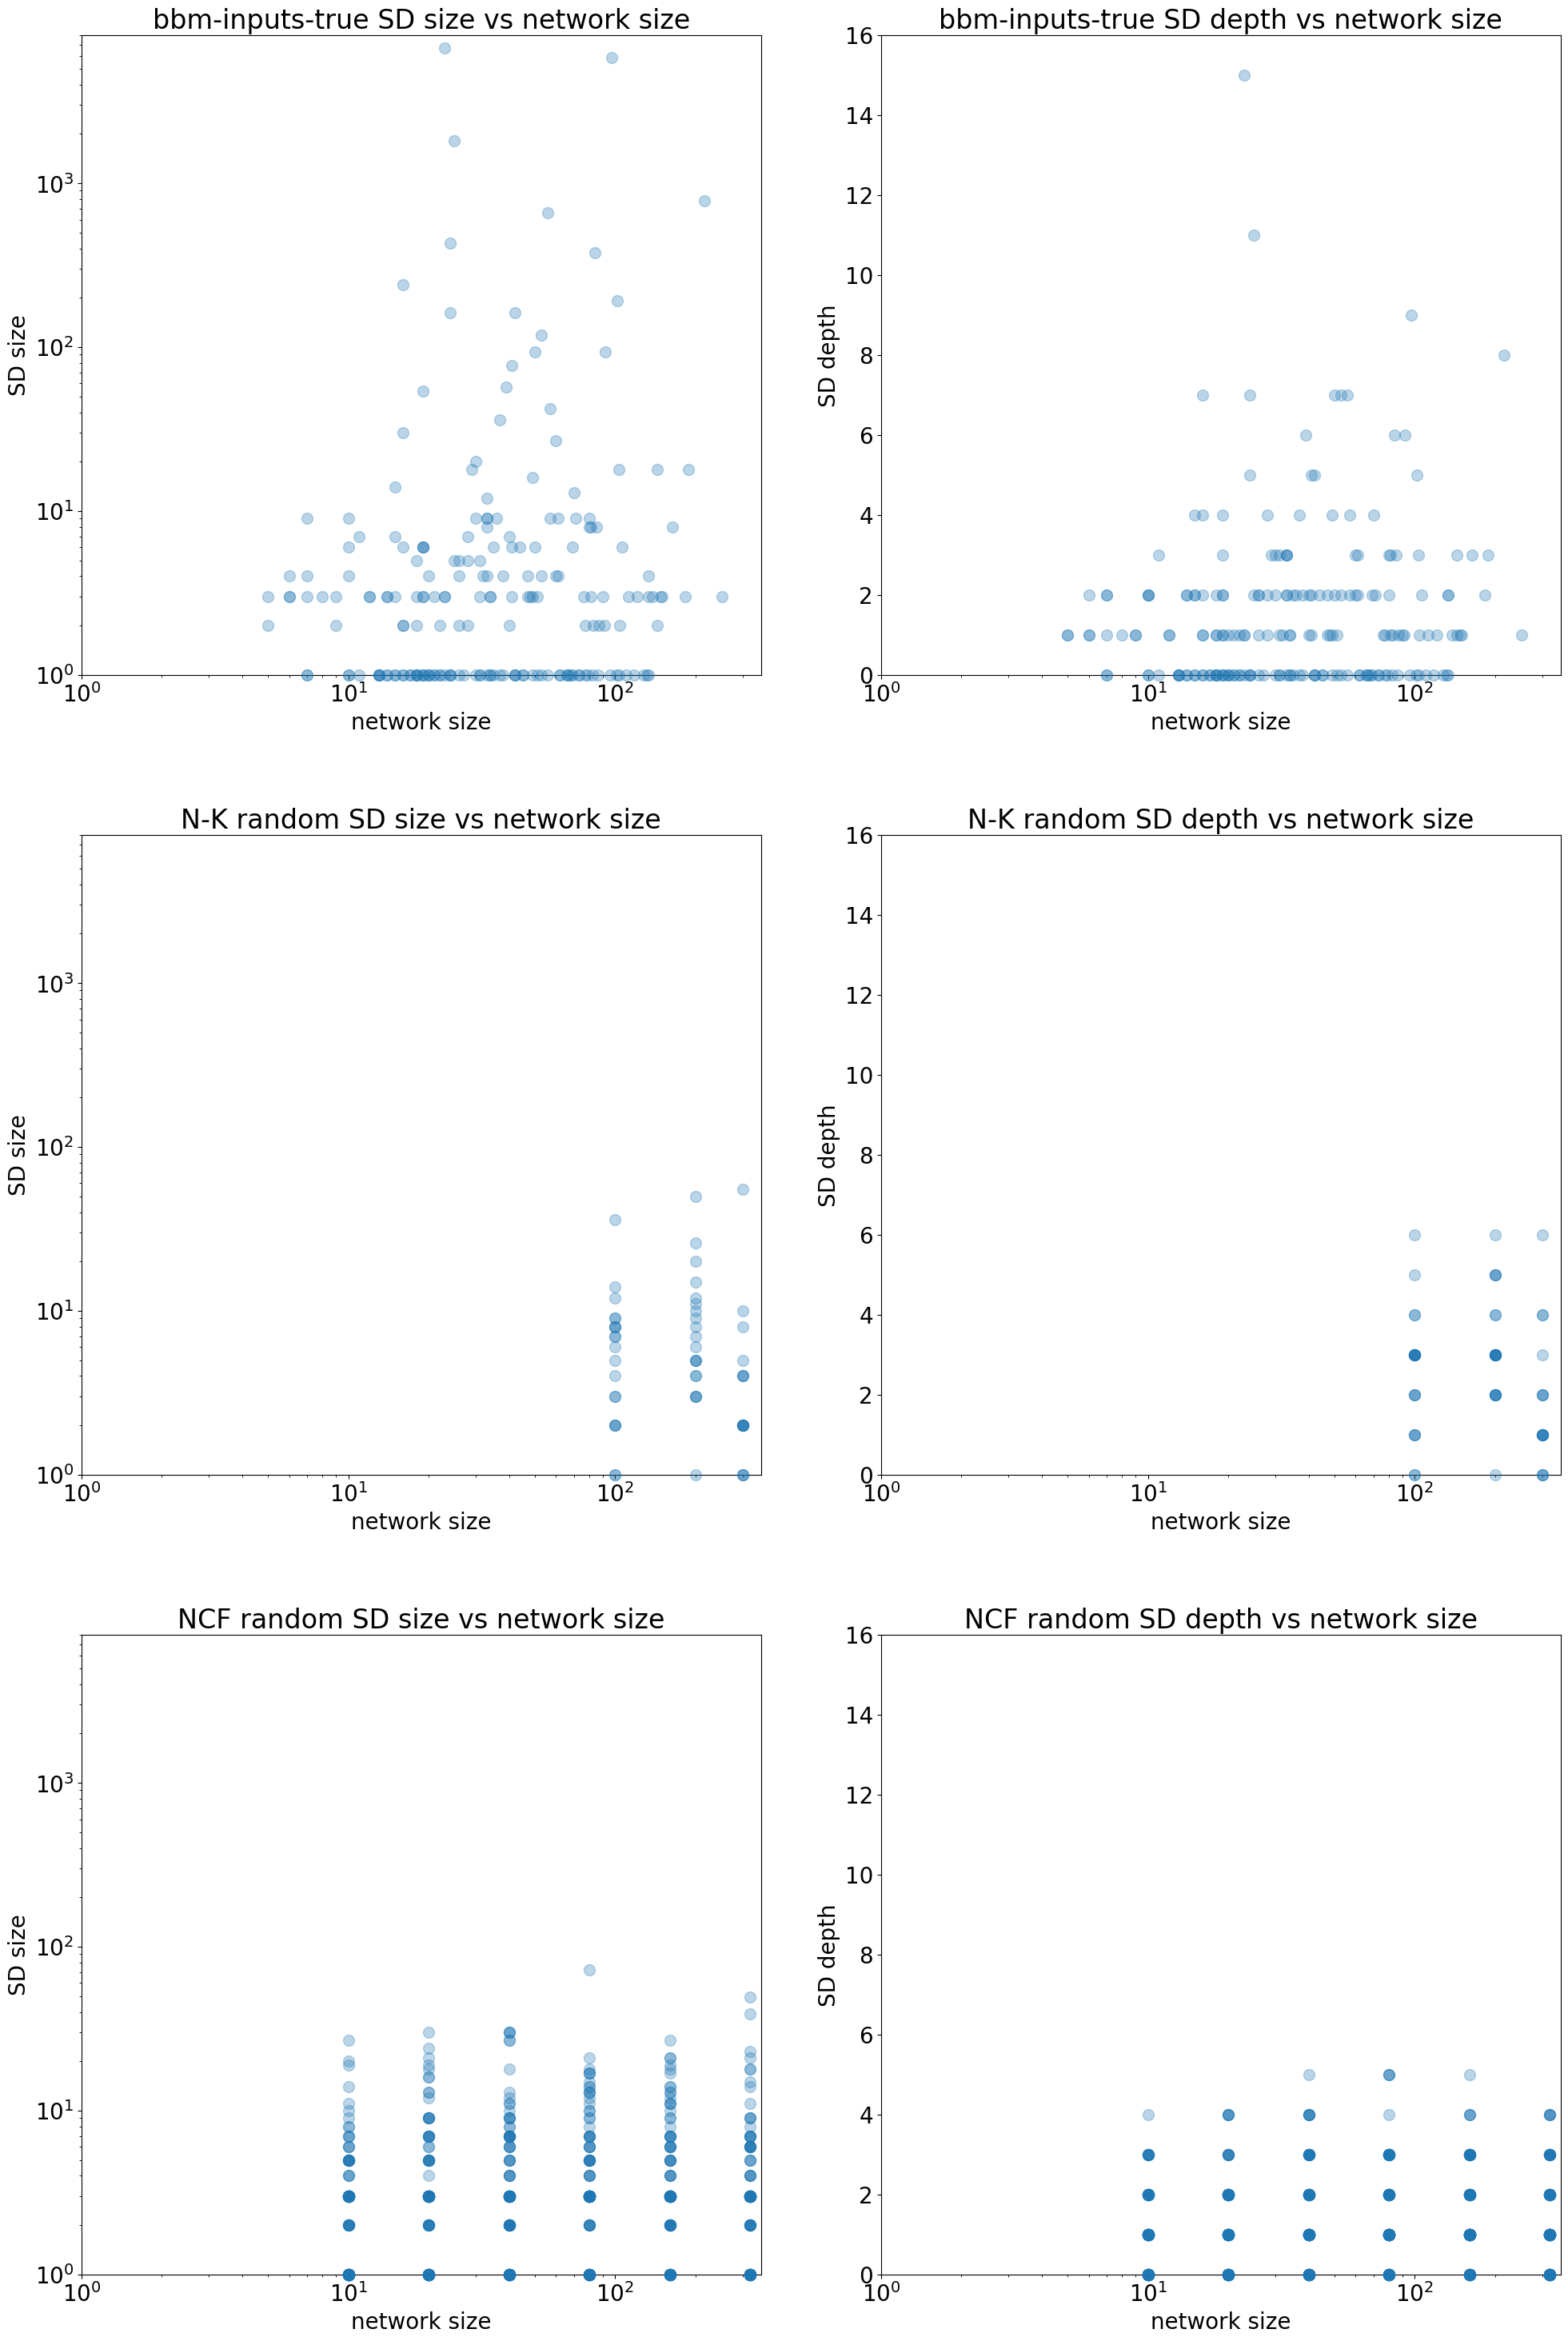

In [53]:
vars = [
    [
        (
            PlotVar(BTR,"n",1,BTR["n"].max()+100,True),
            PlotVar(BTR,"sdsize",1,BTR["sdsize"].max()*1.2,True),
        ),
        (
            PlotVar(BTR,"n",1,BTR["n"].max()+100,True),
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
        ),
    ],
    [
        (
            PlotVar(RAN,"n",1,BTR["n"].max()+100,True),
            PlotVar(RAN,"sdsize",1,BTR["sdsize"].max()*1.2,True),
        ),
        (
            PlotVar(RAN,"n",1,BTR["n"].max()+100,True),
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
        ),
    ],
    [
        (
            PlotVar(NCF,"n",1,BTR["n"].max()+100,True),
            PlotVar(NCF,"sdsize",1,BTR["sdsize"].max()*1.2,True),
        ),
        (
            PlotVar(NCF,"n",1,BTR["n"].max()+100,True),
            PlotVar(NCF,"sddepth",0,BTR["sddepth"].max()+1),
        ),
    ],
]

fig = comparison_plots(vars)

direct fit: R² = 0.5804447899065921
direct fit: Y = e^(0.5909769551630191 * x)
log fit: R² = -231.20443519506568
log fit: Y = e^(0.7920002773064526 * x)
direct fit: R² = 0.5804447899065921
direct fit: Y = e^(0.5909769551630191 * x)
log fit: R² = -231.20443519506568
log fit: Y = e^(0.7920002773064526 * x)
direct fit: R² = 0.8069120903174982
direct fit: Y = e^(0.6297069280748969 * x)
log fit: R² = 0.8084177744756234
log fit: Y = e^(0.6163580650056952 * x)
direct fit: R² = 0.8069120903174982
direct fit: Y = e^(0.6297069280748969 * x)
log fit: R² = 0.8084177744756234
log fit: Y = e^(0.6163580650056952 * x)
direct fit: R² = 0.6077319138040416
direct fit: Y = e^(0.7759435378398021 * x)
log fit: R² = 0.4597727290198115
log fit: Y = e^(0.8252101013191523 * x)
direct fit: R² = 0.6077319138040416
direct fit: Y = e^(0.7759435378398021 * x)
log fit: R² = 0.4597727290198115
log fit: Y = e^(0.8252101013191523 * x)


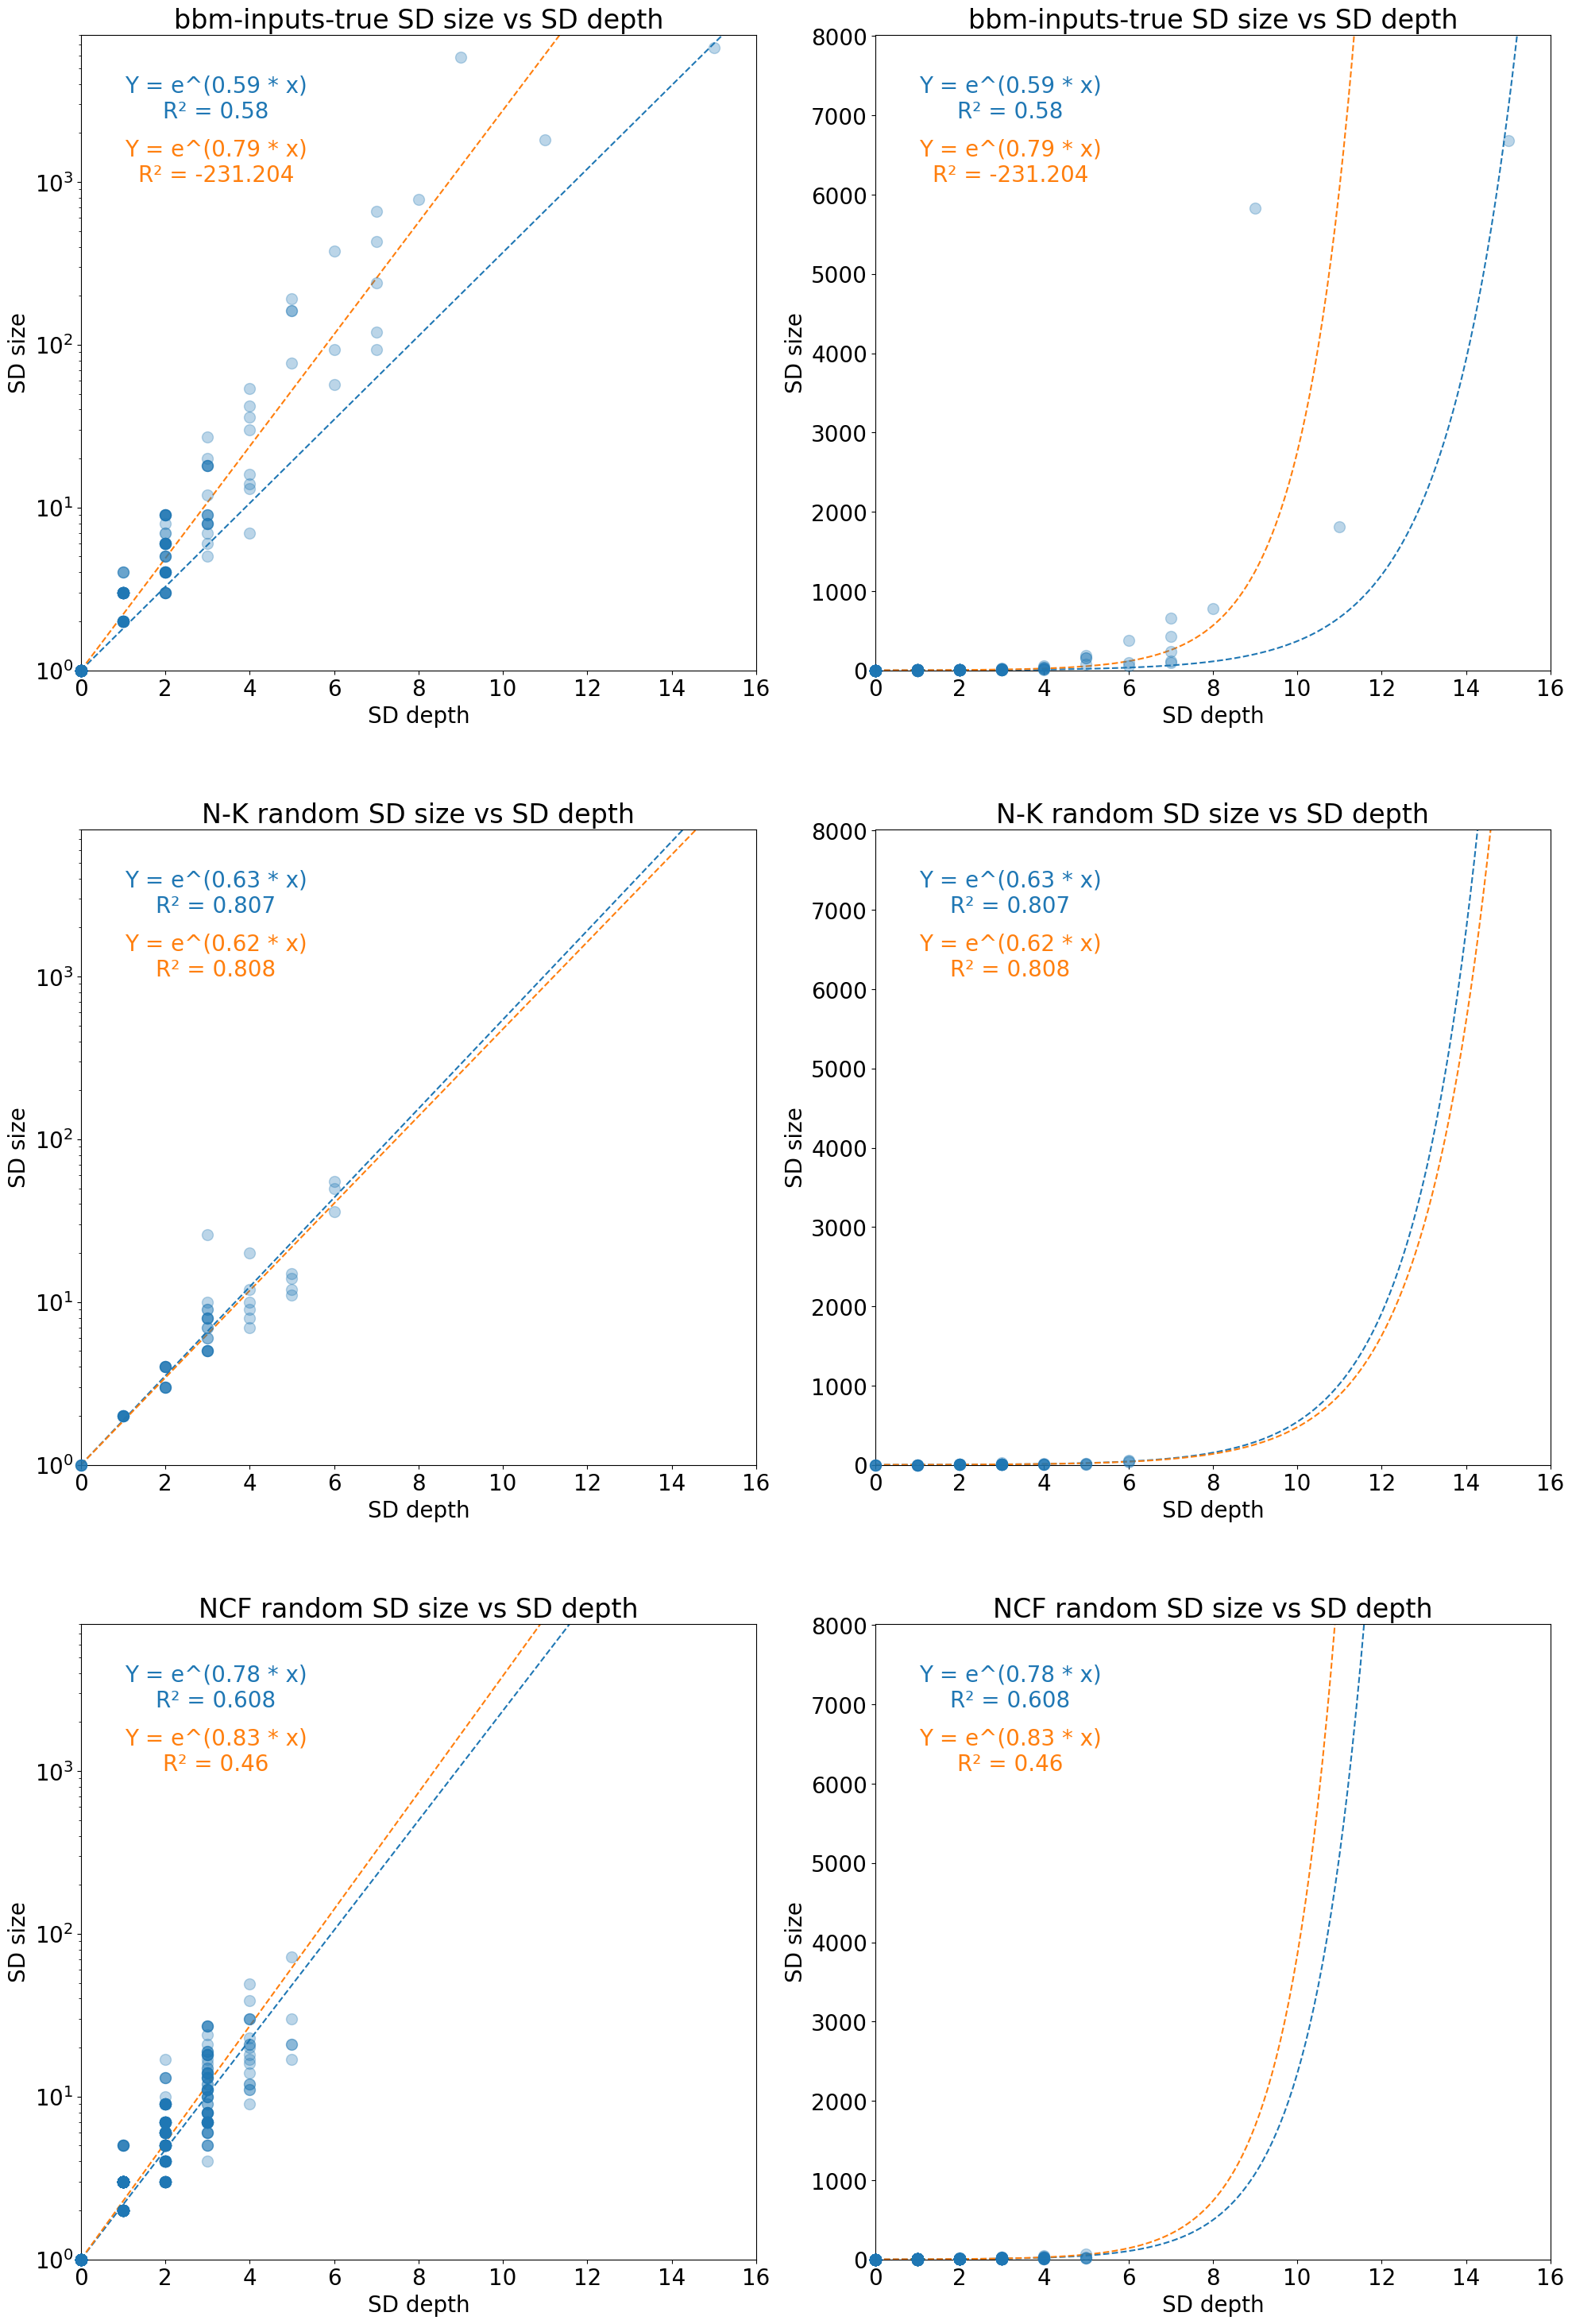

In [54]:
vars = [
    [
        (
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(BTR,"sdsize",1,BTR["sdsize"].max()*1.2,True,True),
        ),
        (
            PlotVar(BTR,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(BTR,"sdsize",0,BTR["sdsize"].max()*1.2,False,True),
        ),
    ],
    [
        (
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(RAN,"sdsize",1,BTR["sdsize"].max()*1.2,True,True),
        ),
        (
            PlotVar(RAN,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(RAN,"sdsize",0,BTR["sdsize"].max()*1.2,False,True),
        ),
    ],
        [
        (
            PlotVar(NCF,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(NCF,"sdsize",1,BTR["sdsize"].max()*1.2,True,True),
        ),
        (
            PlotVar(NCF,"sddepth",0,BTR["sddepth"].max()+1),
            PlotVar(NCF,"sdsize",0,BTR["sdsize"].max()*1.2,False,True),
        ),
    ],
]

fig = comparison_plots(vars)